# Structured Sparsity

## Description

In a target application, we want to sense the components of a signal $\mathbf{x}$, that we indicate as $x_i$, with $ i = 0,\dots, N -1 $. We know that $\mathbf{x}$ is a sparse signal, such that if the  $x_i \, \text{with} \, i < \lfloor \frac{N}{2}\rfloor $ is non-zero, then $x_{i + \lfloor \frac{N}{2}\rfloor }$ is also non-zero. This is to say that the support of the first half and second half of  $\mathbf{x}$ follows the same structure. The goal of this project is to develop and evaluate techniques to recover such sparse signals.

We use $\mathbf{x}$ to denote an Nx1 real-valued sparse vector. The vector of $M$ measurements in our setup is given by $\mathbf{y} = \mathbf{A}\mathbf{x} + \mathbf{v}$ where $\mathbf{A}$ is an $M \times N$ random CS matrix and $\mathbf{v}$ is a a Nx1 vector of white Gaussian noise samples. The entries of $\mathbf{A}$ are drawn from the standard Gaussian Distribution $\mathcal{N}(0,1)$, and then the colums are normalized to have unit $\ell2$ norm. The vector $\mathbf{v}$ is additive white Gaussian noise. In this project, we use $N = 64$. 

In [26]:
%load_ext autoreload
%autoreload 2

# change to False if you don't want to render figures with LaTex
USE_LATEX = True

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact, IntSlider, Layout
from sklearn.linear_model import Lasso, OrthogonalMatchingPursuit
from sklearn.metrics import mean_squared_error
import time
from utils.recover_structured_sparse_signal_with_regularization import recover_structured_sparse_signal_with_regularization
from utils.recover_structured_sparse_signal import recover_structured_sparse_signal

import sys
if sys.version_info[1] >= 11:
    from shutil import which as check_for_installation
else:
    from distutils.spawn import find_executable as check_for_installation

if USE_LATEX and check_for_installation('latex'):
    print('TeX installation found')
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Times",
    })
else:
    print('TeX installation not found')
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    })

# xdata = np.load('data/Project_Structured_Sparsity.npy')
# xdata.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TeX installation found


## Methodology and Evaluation

Conduct a brief literature study to orient yourself on this problem. Implement convex optimization-based algorithms to recover the structured sparse signal. Compare your developed method with a general CS-recovery algorithm (such as ISTA) that does not exploit the structured sparsity.

The methods must be evaluated on the “Project_Structured_Sparsity.npy” dataset using performance metrics such as reconstruction error and computational time. These metrics must be studied as a function of the number of measurements, i.e., $M$. 

Generating sparse vectors with the given structure:

In [27]:
from utils.generate_structured_data import *

M = 26               # Number of Measurements
N = 64              # Number of original variables
NS = 5000           # Number of samples
K = 4               # Number of non-zero entries within the first half of the vector
noise_var = 0.0     # Noise variance

Y, A, X = generate_structured_data(num_measurements=M, num_variables=N, num_samples=NS, sparsity_half=K, noise_var=noise_var)

In [28]:
print(f"Dimensions:\nY = {Y.shape}\nA = {A.shape}\nX = {X.shape}")

Dimensions:
Y = (26, 5000)
A = (26, 64)
X = (64, 5000)


Saving results:

In [29]:
from scipy.io import savemat
out_mat = dict()
out_mat['X'] = X

np.save("data/Project_Structured_Sparsity", X)
savemat("data/Project_Structured_Sparsity.mat", out_mat)

Visualizing our data:

C:\Users\Daniel\AppData\Local\Temp\ipykernel_18756\1797145933.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  snr_db = 10 * np.log10(signal_power / noise_power)


SNR = inf dB


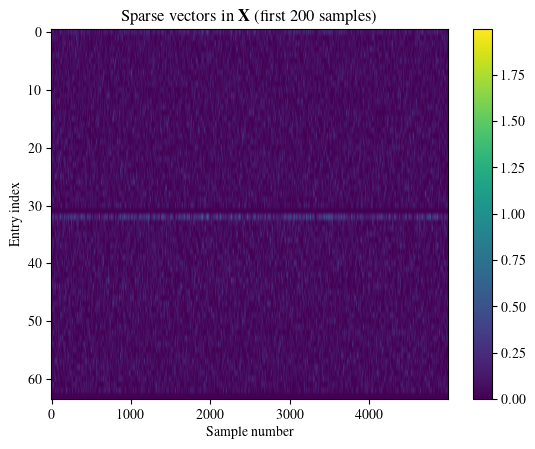

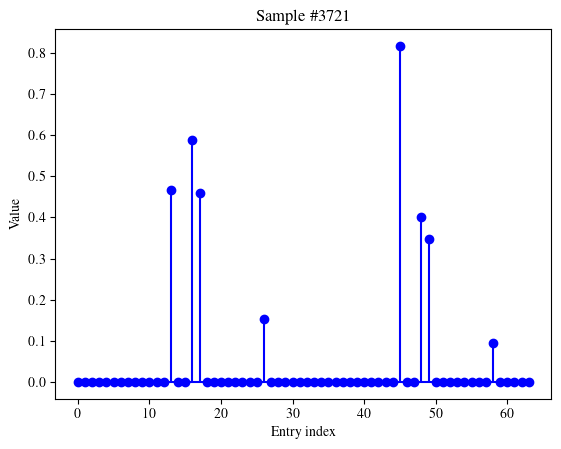

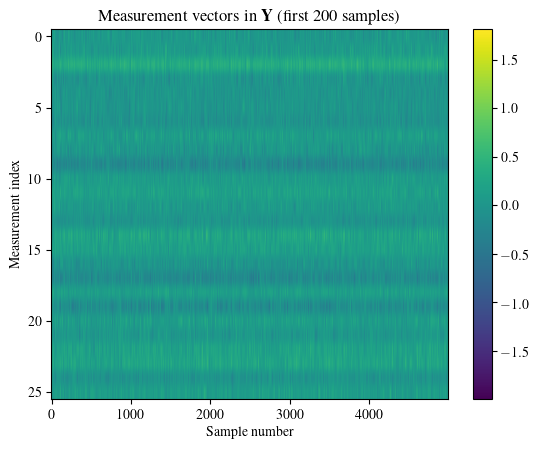

In [30]:
# Plot the first 200 sparse vectors in X
plt.figure()
plt.imshow(X[:,:], aspect='auto')
plt.title(r'Sparse vectors in $\mathbf{X}$ (first 200 samples)')
plt.ylabel(r'Entry index')
plt.xlabel(r'Sample number')
plt.colorbar()

# Plot a single sample from X
plt.figure()
sample_nr = 3721
plt.stem(X[:,sample_nr], linefmt='b', markerfmt='o', basefmt='b')
plt.title(rf'Sample \#{sample_nr}')
plt.xlabel(r'Entry index')
plt.ylabel(r'Value')

# Plot the first 200 measurement vectors in Y
plt.figure()
plt.imshow(Y[:,:], aspect='auto')
plt.title(r'Measurement vectors in $\mathbf{Y}$ (first 200 samples)')
plt.ylabel(r'Measurement index')
plt.xlabel(r'Sample number')
plt.colorbar()

# Signal-to-noise ratio
noise_power = noise_var #np.mean(np.square(V))
signal_power = np.mean(np.square(A @ X))
snr_db = 10 * np.log10(signal_power / noise_power)
print(f"SNR = {snr_db:.2f} dB")

## CS Reconstruction without exploiting support structure

Lasso regression to reconstruct *X* from *Y* and *A*:

In [31]:
# LASSO
# ALPHA = 0.001  # for M = 48 and no noise
ALPHA = 0.001
start_time = time.time()

lasso = Lasso(alpha=ALPHA).fit(A, Y)
X_rec_lasso = lasso.coef_.T

end_time = time.time()
lasso_execution_time = end_time - start_time

# OMP
start_time = time.time()

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=2*K).fit(A, Y)
X_rec_omp = omp.coef_.T

end_time = time.time()
omp_execution_time = end_time - start_time

print(f"LASSO execution time: {lasso_execution_time:.3f} seconds")
print(f"OMP execution time: {omp_execution_time:.3f} seconds")

MSE_lasso = mean_squared_error(X_rec_lasso, X)
MSE_omp = mean_squared_error(X_rec_omp, X)
print(f'Total MSE for LASSO = {MSE_lasso:.4f}')
print(f'Total MSE for OMP = {MSE_omp:.4f}')

# alphas = 0.001 * np.arange(1000)
# mses = np.zeros_like(alphas)
# for i, alpha in enumerate(alphas):
#     lasso_i = Lasso(alpha=alpha).fit(A, Y)
#     X_rec_lasso_i = lasso_i.coef_.T
#     MSE_lasso_i = mean_squared_error(X_rec_lasso_i, X, multioutput='raw_values')
#     mses[i] = np.sum(MSE_lasso_i)

# plt.figure()
# plt.plot(mses)
# plt.show

c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.770e-04, tolerance: 2.647e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e-04, tolerance: 2.606e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Daniel\OneDrive\TU Delft\Quarter 3\Data Compression\Assignments\structured-sparse-recovery\.venv\Lib\site-packages\sklearn\li

LASSO execution time: 1.531 seconds
OMP execution time: 0.742 seconds
Total MSE for LASSO = 0.0025
Total MSE for OMP = 0.0120


Results for a given sample:

In [32]:
sample_nr = 5
mse_sample_lasso = mean_squared_error(X_rec_lasso[:,sample_nr], X[:,sample_nr])
mse_sample_omp = mean_squared_error(X_rec_omp[:,sample_nr], X[:,sample_nr])
print(f"MSE of LASSO for sample #{sample_nr} = {mse_sample_lasso:.4f}")
print(f"MSE of OMP for sample #{sample_nr} = {mse_sample_omp:.4f}")

mse_lasso = mean_squared_error(X, X_rec_lasso, multioutput='raw_values')
mse_omp = mean_squared_error(X, X_rec_omp, multioutput='raw_values')

def interactive_plot(sample_nr):
    mse_str_lasso = rf"MSE of LASSO for sample \#{sample_nr} = {mse_lasso[sample_nr]:.4f}"
    mse_str_omp = r"MSE of OMP \hspace{7.5pt} for sample \#" + f"{sample_nr} = {mse_omp[sample_nr]:.4f}"
    
    plt.figure()
    plt.title(r"$\mathbf{X}$ and $\mathbf{X}_\mathrm{rec}$ for the sample \#" + f"{sample_nr}")
    plt.stem(X[:,sample_nr], linefmt='b', markerfmt='o', basefmt='b')
    plt.stem(X_rec_lasso[:,sample_nr], linefmt='r', markerfmt='D', basefmt='r')
    plt.stem(X_rec_omp[:,sample_nr], linefmt='g', markerfmt='D', basefmt='g')
    plt.xlabel(r'Entry Index')
    plt.ylabel(r'Value')
    plt.ylim((-2,2))
    ax = plt.gca()
    plt.text(0.01, 0.99, mse_str_lasso, ha='left', va='top', transform=ax.transAxes)
    plt.text(0.01, 0.95, mse_str_omp, ha='left', va='top', transform=ax.transAxes)
    plt.legend((r"$\mathbf{X}$", r"$\mathbf{X}_\mathrm{rec}^\mathrm{LASSO}$", r"$\mathbf{X}_\mathrm{rec}^\mathrm{OMP}$"))
    plt.show()



interactive_plot = interactive(interactive_plot, sample_nr=IntSlider(min=0, max=X.shape[1]-1, step=1, value=0, description='Sample number:', 
                                                                     layout=Layout(width='500px'), style={'description_width': 'initial'}))
interactive_plot

MSE of LASSO for sample #5 = 0.0001
MSE of OMP for sample #5 = 0.0000


interactive(children=(IntSlider(value=0, description='Sample number:', layout=Layout(width='500px'), max=4999,…

We see that the reconstructed signal is different than the original signal and also the l_0 norms differ:

In [40]:
print(f"Original signal l0 norm = {np.linalg.norm(X[:,sample_nr], ord=0)}")
print(f"Reconstructed signal l0 norm = {np.linalg.norm(X_rec[:,sample_nr], ord=0)}")

Original signal l0 norm = 6.0
Reconstructed signal l0 norm = 3.0


## CS Reconstruction using knowledge of the support structure - Approach 1

Reconstruction for the entire dataset (takes long)

In [46]:
# # Trying to speed up using parallel computing - not working

# def recover_signal(y):
#     return recover_structured_sparse_signal_with_regularization(CS_mat=A, y=y, alpha=0.1)

start_time = time.time()

# X_rec_structured = np.zeros_like(X)
# with Pool() as pool:
#     items = [Y[:,i] for i in range(Y.shape[1])]
#     for i, result in enumerate(pool.starmap(recover_signal, items)):
#         X_rec_structured[:,i] = result

X_rec_structured = np.apply_along_axis(lambda y: recover_structured_sparse_signal_with_regularization(CS_mat=A, y=y, alpha=0.1), axis=1, arr=Y.T).T

end_time = time.time()
structured_execution_time = end_time - start_time
print(f"Structured signal reconstruction execution time: {structured_execution_time:.3f} seconds")

Structured signal reconstruction execution time: 732.401 seconds


In [19]:
# MSE = mean_squared_error(X_rec_structured, X)
# print(f'Total MSE = {MSE:.4f}')

Reconstruction for a single sample:

In [33]:
sample_nr = 2344
X_rec_structured_sample = recover_structured_sparse_signal_with_regularization(A, Y[:,sample_nr], alpha=1)
# X_rec_structured_sample = recover_structured_sparse_signal(A, Y[:,sample_nr], noise_var, c=1.5)
# X_rec_structured_sample = X_rec_structured[:,sample_nr]

mse_sample = mean_squared_error(X_rec_structured_sample, X[:,sample_nr])
print(f"MSE for sample \#{sample_nr} = {mse_sample:.4f}")

# mse = mean_squared_error(X, X_rec_structured, multioutput='raw_values')

def interactive_plot(sample_nr):
    X_rec_structured_sample = recover_structured_sparse_signal_with_regularization(A, Y[:,sample_nr], alpha=1)
    mse_sample = mean_squared_error(X_rec_structured_sample, X[:,sample_nr])

    # mse_str = rf"MSE for sample \#{sample_nr} = {mse[sample_nr]:.4f}"
    mse_str = rf"MSE for sample \#{sample_nr} = {mse_sample:.4f}"
    
    plt.figure()
    plt.ion()
    plt.title(r"$\mathbf{X}$ and $\mathbf{X}_\mathrm{rec}$ for the sample \#" + f"{sample_nr}")
    plt.stem(X[:,sample_nr], linefmt='b', markerfmt='o', basefmt='b')
    plt.stem(X_rec_structured_sample, linefmt='r', markerfmt='D', basefmt='r')
    plt.xlabel(r'Entry Index')
    plt.ylabel(r'Value')
    plt.ylim((-2,2))
    ax = plt.gca()
    plt.text(0.01, 0.99, mse_str, ha='left', va='top', transform=ax.transAxes)
    plt.legend((r"$\mathbf{X}$", r"$\mathbf{X}_\mathrm{rec,reconstructed}$"))
    plt.show()



interactive_plot = interactive(interactive_plot, sample_nr=IntSlider(min=0, max=X.shape[1]-1, step=1, value=0, description='Sample number:', 
                                                                     layout=Layout(width='500px'), style={'description_width': 'initial'}))
interactive_plot

MSE for sample \#2344 = 0.0393


interactive(children=(IntSlider(value=0, description='Sample number:', layout=Layout(width='500px'), max=4999,…

In [24]:
print(f"Original signal l0 norm = {np.linalg.norm(X[:,sample_nr], ord=0)}")
print(f"Reconstructed signal l0 norm = {np.linalg.norm(X_rec_structured_sample, ord=0)}")

Original signal l0 norm = 8.0
Reconstructed signal l0 norm = 64.0


'0'